In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

In [3]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Implementation of the black-scholes formula. Calculate a price for European call or put options.

    Inputs:
        S [float]: Current stock price
        K [float]: Strike price
        T [float]: Time to maturity (years)
        r [float]: Risk-free interest rate
        sigma [float]: Volatility
        option_type [str]: "call" or "put"

    Returns [float]: Option price
    """

    d1 = (np.log(S / K) + (r + ((sigma**2) / 2))*T) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))

    if (option_type.lower() == "call"):
        return ((norm.cdf(d1) * S) - (norm.cdf(d2) * K * np.exp(-r * T)))
    elif (option_type.lower() == "put"):
        return ((norm.cdf(-d2) * K * np.exp(-r * T)) - norm.cdf(-d1) * S)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")


In [5]:
def sim_paths_bsdstr(num_paths: int, fwds: np.ndarray, fwd_times: np.ndarray, vol: float) -> np.ndarray:
    """
    Generates paths simulating asset prices given forwards, vol, and a number of paths.

    Inputs:
        num_paths [int]: Number of simulation paths
        fwds [np.ndarray]: Forward prices at specific time points
        fwd_times [np.ndarray]: Times corresponding to the forward prices
        vol [float]: Fixed volatility

    Returns:
        np.ndarray: Simulated paths of shape (num_paths, len(fwds))
    """
    
    assert (fwd_times[0] == 0)
    assert (len(fwds) == len(fwd_times))
    
    num_steps = len(fwds)
    paths = np.zeros((num_paths, num_steps))
    paths[:, 0] = fwds[0]  # initialize all paths with initial 'spot price'
    
    # time increments (dt)
    dt = np.diff(fwd_times)
    
    for i in range(1, num_steps):

        z = np.random.randn(num_paths) # Z~N(0,1)
        
        Q = (fwds[i] / fwds[i-1]) * np.exp(-0.5 * (vol**2) * dt[i-1]) # normalization factor
        
        paths[:, i] = paths[:, i-1] * np.exp(vol * np.sqrt(dt[i-1]) * z) * Q
    
    return paths


In [7]:
def make_trivial_fwds(value0: float, num_fwds: int, growth: float = 0.02) -> tuple[np.ndarray, np.ndarray]:
    """
    For testing. Given an initial value, number of forwards, and growth rate, generate 
    evenly spaced times and forwards with fixed growth.

    Inpits:
        value0 [float]: Initial forward value
        numFwds [int]: Number of forwards to generate
        growth [float]: Fixed growth rate per time step

    Returns tuple[np.ndarray, np.ndarray]: Forward prices and corresponding times as NumPy arrays
    """
    times = np.arange(num_fwds)
    fwds = value0 * (1 + growth) ** times

    return fwds, times

def viz_paths_fwds(paths: np.ndarray, fwds: np.ndarray, times: np.ndarray, time_scale: str) -> None:
    """
    Visualize simulated paths around fixed forwards labeled in red.

    Inpits:
        paths [np.ndarray]: Simulated paths of shape (num_paths, num_fwds)
        fwds [np.ndarray]: Forward prices (1D array)
        times [np.ndarray]: Corresponding times (1D array)

    Returns None
    """
    assert len(fwds) == len(times)

    plt.figure(figsize=(12, 8))
    
    # plot the forward curve
    plt.plot(times, fwds, color='red', label='Forwards', linewidth=2)
    
    for path in paths:
        plt.plot(times, path)
    
    plt.title(f"Monte Carlo Simulation: {paths.shape[0]} Simulated Paths On {len(fwds)-1} {time_scale}")
    plt.xlabel("Time")
    plt.ylabel("Asset Price")
    plt.legend(loc="upper left")
    plt.show()

In [9]:
def euro_call_pricing(paths: np.ndarray, strike: float, textOutput: bool = False, maturity=0) -> float | str:
    """
    Calculate the fair price of a European call option using Monte Carlo simulation.

    Inputs:
        paths [np.ndarray]: Simulated paths of asset prices
        strike [float]: Strike price of the option
        textOutput [bool]: If True, return descriptive text output; otherwise, return the fair price
        maturity [float]: T

    Returns:
        float | str: Fair price of the call option, or a descriptive string if textOutput=True
    """
    
    prices_at_maturity = paths[:, -1] # prices at maturity
    
    payoffs = np.maximum(0, prices_at_maturity - strike)
    
    fair_price = np.mean(payoffs)
    
    if textOutput:
        return (f"Simulated {paths.shape[0]} paths with spot price of ${paths[0, 0]:.2f} "
                f"for ${strike} strike at {maturity}-year maturity, fair price: ${fair_price:.2f}")
    
    return fair_price


In [11]:
def sim(S, r, vol, num_paths, num_fwds, time_scale="years"):
    """
    Simulate asset price paths.

    Inputs:
        S [float]: Initial price
        r [float]: Risk-free interest rate (annualized)
        vol [float]: Volatility (annual)
        num_paths [int]: Number of paths to simulate
        num_fwds [int]: Number of forwards about which to generate paths
        time_scale [str]: "days" , "months" , "years"

    Returns None
    """

    if time_scale.lower() == "days":
        vol = vol / np.sqrt(252)
        r = r / 365
    elif time_scale.lower() == "months":
        vol = vol / np.sqrt(12)
        r = r / 365
    
    fwds, ftimes = make_trivial_fwds(S, num_fwds, r)
    paths = sim_paths_bsdstr(num_paths, fwds, ftimes, vol)
    viz_paths_fwds(paths, fwds, ftimes, time_scale)

    return paths

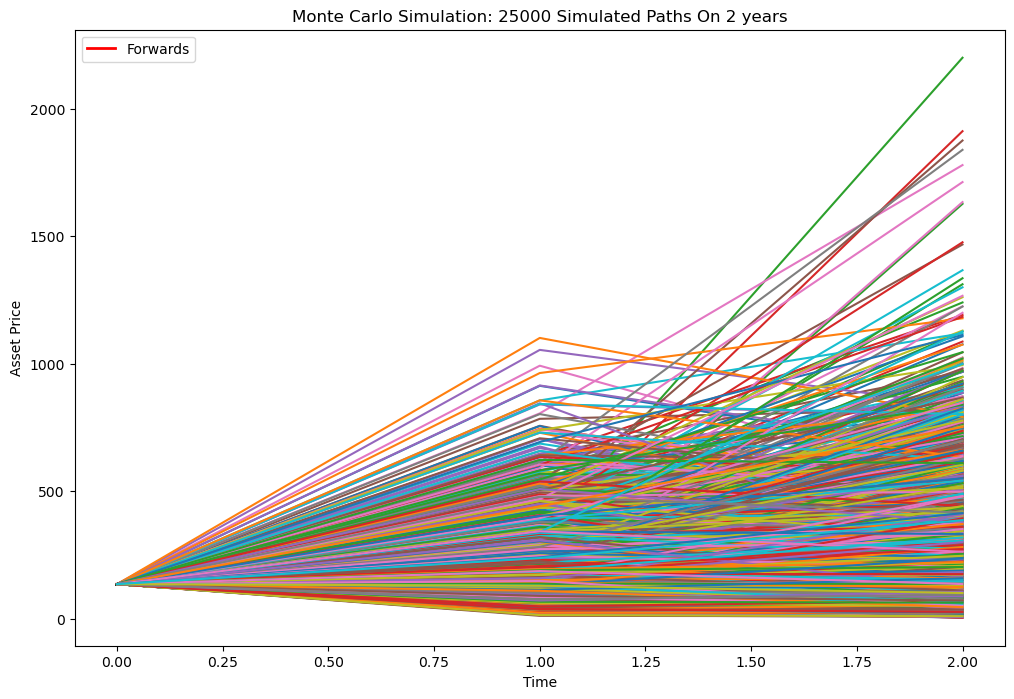

'Simulated 25000 paths with spot price of $135.91 for $136 strike at 3-year maturity, fair price: $48.81'

In [13]:
# Example 1:
paths = sim(135.91, 0.0467, 0.5463, 25000, 3, "years")
euro_call_pricing(paths, 136, True, 3)

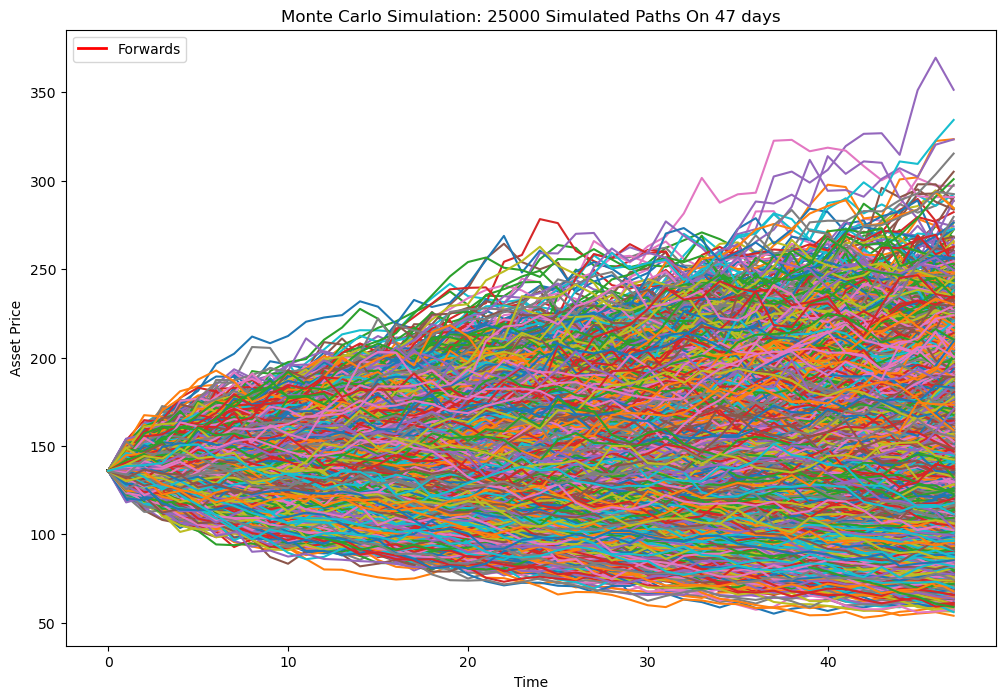

'Simulated 25000 paths with spot price of $135.91 for $136 strike at 0.13150684931506848-year maturity, fair price: $13.10'

In [17]:
# Example 2:
paths = sim(135.91, 0.0467, 0.5463, 25000, 48, "days")
euro_call_pricing(paths, 136, True, 48/365)

In [27]:
# compare with closed-form solution
print("example 1: $" + str(black_scholes(135.91, 136, 3, 0.0467, 0.5463, "call")))

print("example 2: $" + str(black_scholes(135.91, 136, 0.13150684931506848, 0.0467, 0.5463, "call")))

example 1: $55.54311401434553
example 2: $11.070118164245983
